# Time Series Anomaly Detection Exercises

The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is curriculum_logs.

## 1. Label students by the program they are in.

In [12]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import env


In [1]:

# Getting conncection to mySQL database, and acquiring data
def get_connection(db, user=env.user, host=env.host, password=env.password):
    '''
    This function gets conncection to mySQL database
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

# Loading raw data from Curriculum_Log database
def new_data():
    '''
    This function reads the curriculum data from the mySQL database into a df.
    '''
    # Create SQL query.
    sql_query = '''
    SELECT 
        date,
        time,
        ip,
        path,
        user_id,
        cohort_id,
        name as cohort_name,
        slack,
        start_date,
        end_date,
        program_id
    FROM
        curriculum_logs.logs
    join
        curriculum_logs.cohorts on cohort_id = id
    ;
    '''
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('curriculum_logs'))
    
    return df

In [2]:
df = new_data()

In [3]:
# Encode program_id
df['program'] = df.program_id.map({1: 'Full Stack PHP', 2: 'Full Stack Java', 3: 'Data Science', 4: 'Front End'})

In [6]:
# Change date columns to datetime
df.date = pd.to_datetime(df.date)
df.start_date = pd.to_datetime(df.start_date)
# Set date columns as datatime as index
df = df.set_index(df.date)

## 3. Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.

In [7]:
grads = pd.DataFrame(df[df.date>df.end_date].program.value_counts())

In [8]:
grads

,program
Full Stack Java,157786
Full Stack PHP,30548
Data Science,11495
Front End,5


Text(0, 0.5, 'No. of Log Entry')

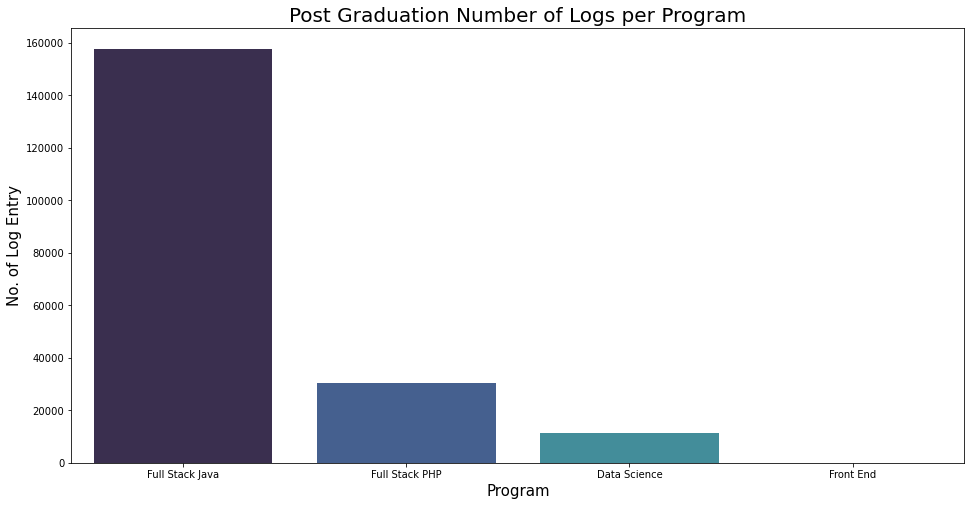

In [13]:
# Visualizing number of entry
plt.figure(figsize=(16,8))
sns.barplot(x=grads.index, y=grads.program,palette = 'mako')
plt.title('Post Graduation Number of Logs per Program', fontsize = 20)
plt.xlabel('Program', fontsize = 15)
plt.ylabel('No. of Log Entry', fontsize = 15)

**These students from 4 programs are accessing the curriculum post graduation.**

## 4. Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2.

### Bollinger Bands and Percent Bandwidth (%b)

#### Bollinger Bands
- indicates volatility, commonly used in stock market trading.

- Comprises 3 lines: Upper Band (UB), Lower Band (LB), and Midband.

#### Midband
- The Exponential Moving Average

- midband = train.ewm(span=30).mean()

#### Upper & Lower Band
- UB/LB = Midband +/- stdev * K

- stdev = train.ewm(span=30).std()

- K = the number of standard deviations to go up and down from the EMA

#### %b, Percent Bandwidth
- Shows where the last value sits in relation to the bands

- %b = || (last-LB)/(UB-LB)

- %b > 1 ||=> point lies above UB

- %b < 0 ||=> point lies beyond LB

- %b == .5 ||=> point lies on the midband

#### Bandwidth
- The width of the bands

- **Bandwidth = (UB-LB)/Midband**

In [20]:
pages = df['path'].resample('d').count()
# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()

midband.head()

date
2018-01-26    533.000000
2018-01-27    376.450000
2018-01-28    302.284709
2018-01-29    434.739290
2018-01-30    475.525441
Freq: D, Name: path, dtype: float64

In [21]:
# compute exponential stdev
stdev = pages.ewm(span=span).std()

stdev.head()
# the initial NaN is inevitable

date
2018-01-26           NaN
2018-01-27    214.253355
2018-01-28    192.738756
2018-01-29    292.489456
2018-01-30    262.780177
Freq: D, Name: path, dtype: float64

In [22]:
# upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3

In [23]:
ub

date
2018-01-26            NaN
2018-01-27    1019.210064
2018-01-28     880.500977
2018-01-29    1312.207658
2018-01-30    1263.865971
                 ...     
2021-04-17    3539.572262
2021-04-18    3480.391221
2021-04-19    3565.644683
2021-04-20    3575.685641
2021-04-21    3495.320435
Freq: D, Name: path, Length: 1182, dtype: float64

In [24]:
lb

date
2018-01-26           NaN
2018-01-27   -266.310064
2018-01-28   -275.931559
2018-01-29   -442.729079
2018-01-30   -312.815089
                 ...    
2021-04-17   -912.134710
2021-04-18   -938.465770
2021-04-19   -909.520874
2021-04-20   -843.053691
2021-04-21   -796.148610
Freq: D, Name: path, Length: 1182, dtype: float64

In [26]:
# concatenate ub and lb together into one df, bb
bands = pd.concat([ub, lb], axis=1)

bands.columns = ['ub', 'lb']
bands.head()

,ub,lb
date,,
2018-01-26,NaN,NaN
2018-01-27,1019.210064,-266.310064
2018-01-28,880.500977,-275.931559
2018-01-29,1312.207658,-442.729079
2018-01-30,1263.865971,-312.815089


In [28]:
band_df = pd.concat([pages, midband, bands], axis=1)
band_df.columns = ['pages', 'midband', 'ub', 'lb']
band_df.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,533,533.000000,NaN,NaN
2018-01-27,230,376.450000,1019.210064,-266.310064
2018-01-28,168,302.284709,880.500977,-275.931559
2018-01-29,783,434.739290,1312.207658,-442.729079
2018-01-30,614,475.525441,1263.865971,-312.815089


## 5. Plot the access activity of these students.

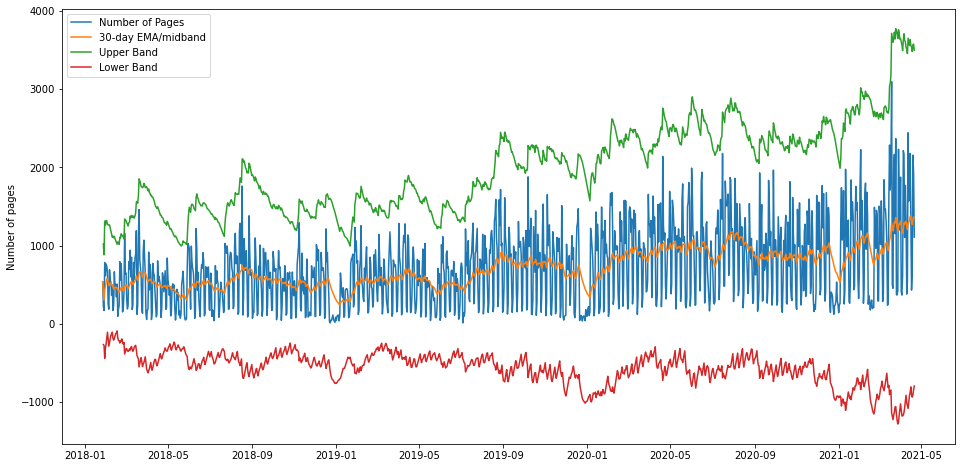

In [31]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(band_df.index, band_df.pages, label='Number of Pages')
ax.plot(band_df.index, band_df.midband, label = '30-day EMA/midband')
ax.plot(band_df.index, band_df.ub, label = 'Upper Band')
ax.plot(band_df.index, band_df.lb, label = 'Lower Band')
ax.legend(loc='best')
ax.set_ylabel('Number of pages')
plt.show()